### Reading in Historic Wildfire Data

Reading in fire shapefile.

In [108]:
# import geopandas, looks like it's similar to simple featurs
import geopandas as gp # geopandas brings in shapefiles as dataframe with spatial information
import pandas as pd # pandas dataframe
import numpy as np # numpy to create new array
# interpolate griddate
from scipy import interpolate
# plots
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Read in 1980 to 2016 wildfire data.

In [2]:
fires = gp.read_file('../data/wf_usfs_1980_2016/wf_usfs_1980_2016.shp')

View head of fires geopandas dataframe.

In [3]:
fires.head()

,ORGANIZATI,UNIT,SUBUNIT,SUBUNIT2,FIREID,FIRENAME,FIRENUMBER,FIRECODE,CAUSE,SPECCAUSE,...,DLONGITUDE,TOTALACRES,TRPGENCAUS,TRPSPECCAU,Cat_Field,DuplicateF,FireName_A,Keep,Duplicate_,geometry
0,FS,06,0616,Wallowa-Whitman National Forest,6752594,Elk Creek,056,EK2N,Human,9,...,-117.934167,0.3,8,9,EK2N/2016/Oregon/ELK CREEK,EK2N,ELK CREEK,None,0,POINT (-117.9341666698559 44.74138889038505)
1,FS,06,0602,Fremont-Winema National Forest,6770108,Indian,028,KMG9,Human,9,...,-122.190000,0.1,8,9,KMG9/2016/Oregon/INDIAN,None,INDIAN,None,0,POINT (-122.1899999996003 42.39722221982964)
2,FS,08,0809,Ouachita National Forest,6757702,Sweetwater,067,KHE1,Natural,1,...,-93.436111,315.0,0,1,KHE1/2016/Arkansas/SWEETWATER,None,SWEETWATER,None,0,POINT (-93.4361111097399 34.75694443973418)
3,FS,03,0307,Kaibab National Forest,6768482,STINA,042,EKV6,Natural,1,...,-112.333056,0.5,0,1,EKV6/2016/Arizona/STINA,EKV6,STINA,None,0,POINT (-112.3330555596663 36.37361110976497)
4,FS,01,0118,Dakota Prairie Grasslands,6775526,5A,015,EKT6,Natural,1,...,-102.401667,2.5,0,1,EKT6/2016/South Dakota/5A,EKT6,5A,None,0,POINT (-102.4016666697809 45.82166667028065)


In [4]:
# view variable names
fires.dtypes

ORGANIZATI     object
UNIT           object
SUBUNIT        object
SUBUNIT2       object
FIREID         object
FIRENAME       object
FIRENUMBER     object
FIRECODE       object
CAUSE          object
SPECCAUSE       int64
STATCAUSE       int64
SIZECLASS      object
SIZECLASSN    float64
FIRETYPE       object
PROTECTION     object
FIREPROTTY     object
YEAR_          object
FiscalYear      int64
STARTDATED     object
CONTRDATED     object
OUTDATED       object
GACC           object
DISPATCH       object
STATE          object
STATE_FIPS     object
FIPS          float64
DLATITUDE     float64
DLONGITUDE    float64
TOTALACRES    float64
TRPGENCAUS      int64
TRPSPECCAU      int64
Cat_Field      object
DuplicateF     object
FireName_A     object
Keep           object
Duplicate_      int64
geometry       object
dtype: object

In [5]:
# view first 5 dates
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']][:5]

,STARTDATED,CONTRDATED,OUTDATED
0,2016-10-02,2016-10-04,2016-10-14
1,2016-08-17,2016-08-17,2016-08-17
2,2016-07-22,2016-08-16,2016-09-02
3,2016-07-19,2016-07-21,2016-07-25
4,2016-07-14,2016-07-22,2016-07-22


Convert dates to datetime.

In [6]:
# convert date variables to date time
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']] = (fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']]
                                                      .apply(pd.to_datetime, errors = 'coerce'))

In [7]:
# check to make sure it's now a date time
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']].dtypes

STARTDATED    datetime64[ns]
CONTRDATED    datetime64[ns]
OUTDATED      datetime64[ns]
dtype: object

### Assigning Grid ID to Fire ID

I want to extract the latitude and longitude of each fire and find what grid ID it's closest to and assign it that grid ID. This will allow me to join climate predictor features to the fire event.

In [58]:
# latitude and longitude values and fire ids
f_lat = fires['DLATITUDE'].values
f_lon = fires['DLONGITUDE'].values
fire_ids = fires['FIREID'].values

In [59]:
# print first ids of lats lons and fires
print(f_lat[:5])
print(f_lon[:5])
print(fire_ids)

[44.74138889 42.39722222 34.75694444 36.37361111 45.82166667]
[-117.93416667 -122.19        -93.43611111 -112.33305556 -102.40166667]
['6752594' '6770108' '6757702' ... '385060' '310380' '1452438']


Make the same custom grid as my regrided climate data to assign values to.

In [8]:
# custom grids for every degree
# vectors
grid_lat = np.arange(27.5, 50.0, 1)
grid_lon = np.arange(-125.0, -70.0, 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plot points to make sure grid looks right.

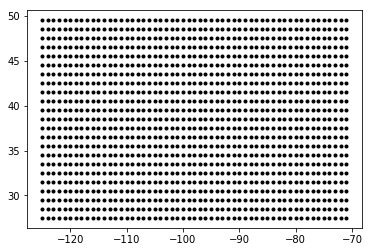

In [11]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

In [14]:
# shape of grid
np.shape(glons)

(23, 55)

Use the new glons and glats coordinates to generate a sequential number of grid IDs.

In [31]:
# grid id array; using reshape of sequential vector of ids, and giving shape of glons
grid_id = np.arange(1, 1266,1)
grid_id_array = np.reshape(grid_id, np.shape(glons))

In [32]:
np.shape(grid_id_array)

(23, 55)

In [45]:
# now I want to assign the grid ID based on the cell/point.
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T
# check dimensions
np.shape(us_grid)

(1265, 2)

Interpolate grid ID to fire coordinates based on nearest neighbor of grid id value.

In [85]:
# set up interpolate to nearest neighbor fuction
near_interp = interpolate.NearestNDInterpolator(us_grid, grid_id)

In [103]:
# apply near_interp to each fire id coordinate
fire_grid_id = near_interp(f_lon, f_lat)

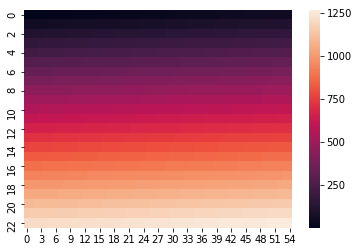

In [110]:
# plotting grid id value array
sns.heatmap(grid_id_array)

In [104]:
# check first couple ids
fire_grid_id[:10]

array([ 943,  829,  418,  509, 1014,  557,  423,  424,  424,  424])

In [113]:
# create dataframe with coordinates, fireid, and gridid
fire_grid = np.concatenate((fire_ids, f_lon, f_lat), axis=0)

In [128]:
# check to make sure fire grid id and fire ids are same dimension
np.shape(fire_grid_id) == np.shape(fire_ids)

True

Create a dataframe of keys that links the grid id to the FIRE ID so I can know the grid the fire took place in.

In [130]:
fire_grid = pd.DataFrame(data = {'lat' : f_lat, 'lon' : f_lon, 'FIREID' : fire_ids, 'grid_id' : fire_grid_id})

In [132]:
# view first couple ids
fire_grid.head()

,lat,lon,FIREID,grid_id
0,44.741389,-117.934167,6752594,943
1,42.397222,-122.190000,6770108,829
2,34.756944,-93.436111,6757702,418
3,36.373611,-112.333056,6768482,509
4,45.821667,-102.401667,6775526,1014


In [142]:
# join grid_id back in to fire geopandas dataframe; inner joining to exclude fires outside my grid like Alaska
fires_w_grid = fires.merge(fire_grid, left_on = 'FIREID', right_on = 'FIREID', how = 'left')

In [156]:
# set grid_id to character and remove duplicates
fires_w_grid['grid_id'] = fires_w_grid['grid_id'].astype(str)
# remove duplicates
fires_w_grid = fires_w_grid[(fires_w_grid.Duplicate_ == 0)]
# add year-month # figure this out later
#fires_w_grid['yrmon'] = fires_w_grid['STARTDATED'].map(lambda x: x.year + x.month)

In [150]:
fires_w_grid['grid_id'][:5]

0     943
1     829
2     418
3     509
4    1014
Name: grid_id, dtype: object

In [153]:
fires_w_grid.shape

(298835, 40)

In [151]:
# shape of fires with grid
fires_w_grid.head()

,ORGANIZATI,UNIT,SUBUNIT,SUBUNIT2,FIREID,FIRENAME,FIRENUMBER,FIRECODE,CAUSE,SPECCAUSE,...,TRPSPECCAU,Cat_Field,DuplicateF,FireName_A,Keep,Duplicate_,geometry,lat,lon,grid_id
0,FS,06,0616,Wallowa-Whitman National Forest,6752594,Elk Creek,056,EK2N,Human,9,...,9,EK2N/2016/Oregon/ELK CREEK,EK2N,ELK CREEK,None,0,POINT (-117.9341666698559 44.74138889038505),44.741389,-117.934167,943
1,FS,06,0602,Fremont-Winema National Forest,6770108,Indian,028,KMG9,Human,9,...,9,KMG9/2016/Oregon/INDIAN,None,INDIAN,None,0,POINT (-122.1899999996003 42.39722221982964),42.397222,-122.190000,829
2,FS,08,0809,Ouachita National Forest,6757702,Sweetwater,067,KHE1,Natural,1,...,1,KHE1/2016/Arkansas/SWEETWATER,None,SWEETWATER,None,0,POINT (-93.4361111097399 34.75694443973418),34.756944,-93.436111,418
3,FS,03,0307,Kaibab National Forest,6768482,STINA,042,EKV6,Natural,1,...,1,EKV6/2016/Arizona/STINA,EKV6,STINA,None,0,POINT (-112.3330555596663 36.37361110976497),36.373611,-112.333056,509
4,FS,01,0118,Dakota Prairie Grasslands,6775526,5A,015,EKT6,Natural,1,...,1,EKT6/2016/South Dakota/5A,EKT6,5A,None,0,POINT (-102.4016666697809 45.82166667028065),45.821667,-102.401667,1014


### Count of Fire Types

In [172]:
fire_counts.dtypes

TOTALACRES  count      int64
            mean     float64
dtype: object

In [179]:
# summarise number of fires; needs reset index
fire_counts = (fires_w_grid[['SIZECLASS', 'TOTALACRES', 'FiscalYear']]
               .groupby(['FiscalYear', 'SIZECLASS']).count().reset_index())

# convert size class to category
fire_counts['SIZECLASS'] = fire_counts['SIZECLASS'].astype('category')

In [180]:
# view first couple
fire_counts.head()

,FiscalYear,SIZECLASS,TOTALACRES
0,1980,A,2379
1,1980,B,1195
2,1980,C,353
3,1980,D,50
4,1980,E,24


In [177]:
fire_counts.dtypes

FiscalYear              int64
SIZECLASS            category
TOTALACRES  count       int64
            mean      float64
dtype: object

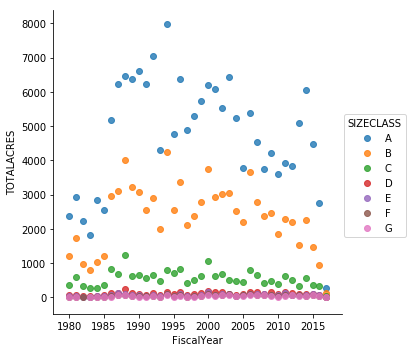

In [186]:
# number of fires by year over time

sns.lmplot(x='FiscalYear', y='TOTALACRES', hue = 'SIZECLASS', fit_reg = False, data = fire_counts)

In [187]:
# avg acres burned 
fire_acres = (fires_w_grid[['TOTALACRES', 'FiscalYear']]
               .groupby(['FiscalYear']).mean().reset_index())

# convert size class to category
fire_acres.head()

,FiscalYear,TOTALACRES
0,1980,24.090394
1,1981,27.215509
2,1982,9.676165
3,1983,17.823582
4,1984,11.103539


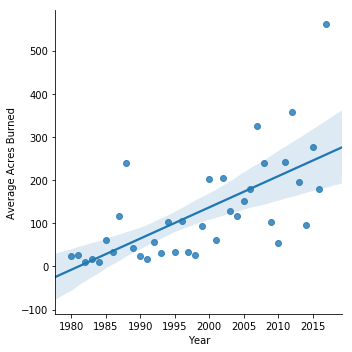

In [193]:
# number of fires by year over time
ax = sns.lmplot(x='FiscalYear', y='TOTALACRES', data = fire_acres)
ax.set(xlabel = 'Year', ylabel = 'Average Acres Burned')